In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from sm_utils import make_train_data,  make_test_data, df_to_md_table
from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data/'

def prev_month(ym):
    prev_month = datetime.strptime(ym, '%Y%m') + relativedelta(months=-1)
    return datetime.strftime(prev_month, '%Y%m')

## load model

In [5]:
clf_dict = {}

with open(os.path.join(DATA_PATH, 'upsell_old_model.pkl'), 'rb') as f:
    clf_dict['old'] = pickle.load(f)

In [19]:
with open(os.path.join(DATA_PATH, 'upsell_new_model_1.pkl'), 'rb') as f:
    clf_dict['new1'] = pickle.load(f)

In [7]:
with open(os.path.join(DATA_PATH, 'upsell_new_model_2.pkl'), 'rb') as f:
    clf_dict['new2'] = pickle.load(f)

In [20]:
clf_dict

{'old': <lightgbm.basic.Booster at 0x7f3103f7ee10>,
 'new2': <lightgbm.basic.Booster at 0x7f311884ed30>,
 'new1': <lightgbm.basic.Booster at 0x7f2fd88aba90>}

## load test data

In [11]:
sql = """
select 
    b.*
,   a.bf_prod_id as label_bf_prod_id
,   a.af_prod_id as label_af_prod_id
,   a.plan_chg_yn as label_plan_chg_yn
,   a.upsell_yn as label_upsell_yn
,   a.diff as label_diff
,   a.eqp_chg_yn as label_eqp_chg_yn
,   a.af_channel as label_af_channel
,   a.ym as a_ym
,   b.ym as b_ym
from dumbo.dominic_upsell_label a
join comm.user_input_matrix_for_upsell_monthly b
on a.svc_mgmt_num = b.svc_mgmt_num 
and b.ym = date_format(add_months(from_unixtime(unix_timestamp(a.ym,'yyyyMM'),'yyyy-MM-dd'),-1), 'yyyyMM')
where a.ym = '201909'
and a.age between 19 and 70 
"""

In [12]:
df_tst = load_from_hive(hive_connection('dmig'), sql)

2019-11-04 15:58:03,549 - YE_HIVE - INFO - ...tmp_db name = tmp_20191104_15_58_03_7691572070aa7be6adab6cc6fdda421effc31600
2019-11-04 15:58:03,552 - YE_HIVE - INFO - Start creating table
2019-11-04 15:58:03,553 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191104_15_58_03_7691572070aa7be6adab6cc6fdda421effc31600
2019-11-04 15:58:03,610 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191104_15_58_03_7691572070aa7be6adab6cc6fdda421effc31600' is done
2019-11-04 16:01:23,509 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191104_15_58_03_7691572070aa7be6adab6cc6fdda421effc31600 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select 
    b.*
,   a.bf_prod_id as label_bf_prod_id
,   a.af_prod_id as label_af_prod_id
,   a.plan_chg_yn as label_plan_chg_yn
,   a.upsell_yn as label_upsell_

In [13]:
df_tst.shape

(15421383, 91)

## preprocess

In [14]:
df_tst.shape

(15421383, 91)

In [15]:
df_tst.channel.fillna('NAN', inplace=True)
df_tst.drop(['nm_cust_num', 'a_ym', 'b_ym'], axis=1, inplace=True)

In [16]:
## load label encoder
with open(os.path.join(DATA_PATH, 'upsell_test_1104_2.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

In [17]:
le_dict

defaultdict(sklearn.preprocessing.label.LabelEncoder,
            {'channel': LabelEncoder(), 'label_upsell_yn': LabelEncoder()})

In [18]:
for c, d in le_dict.items():
    df_tst[c] = d.transform(df_tst[c])

## predict

In [22]:
label_cols = [c for c in df_tst.columns if 'label_' in c]

# columns
idx_col = 'svc_mgmt_num'
target_col = 'label_upsell_yn'
del_cols = [idx_col, target_col, 'ym'] 
del_cols += label_cols
feature_cols = [col for col in df_tst.columns if col not in del_cols]

In [24]:
for name, clf in clf_dict.items():
    print('='* 50)
    print('name: ', name)
    
    score = '{}_score'.format(name)
    pred_class = '{}_pred_class'.format(name)
    
    df_tst[score] = clf.predict(df_tst[feature_cols], num_threads=40)
    
    df_tst[pred_class] = df_tst[score]>0.5
    df_tst[pred_class] = df_tst[pred_class].astype(int)

name:  old
name:  new2
name:  new1


In [25]:
df_tst.head()

svc_mgmt_num  sex_cd  age  svc_gr  mng_nice_cb_scr  mng_nice_cb_grd  \
0   1000025618       1   56       1              870                2   
1   1000039707       1   54       3              863                3   
2   1000063712       0   38       2              912                1   
3   1000077504       1   52       2              798                5   
4   1000133101       1   62       1              948                1   

   svc_scrb_period  last_equip_period  bas_fee_amt  bas_ofr_data_gb  ...  \
0             5659                 31        55000           9.0000  ...   
1             8644                -20        95000        5000.0000  ...   
2             6184                119        50000           4.0000  ...   
3             8668                866        56100           6.5000  ...   
4             8869               4647        12100           0.0001  ...   

   label_upsell_yn  label_diff  label_eqp_chg_yn  label_af_channel  old_score  \
0                0           0                 0              오프라인   0.027740   
1                0           0                 0              오프라인   0.000560   
2                0           0                 0               T월드   0.148530   
3                0           0                 0              고객센터   0.607927   
4                0           0                 0              오프라인   0.459581   

   old_pred_class  new2_score  new2_pred_class  new1_score  new1_pred_class  
0               0    0.116502                0    0.034129                0  
1               0    0.005657                0    0.002107                0  
2               0    0.320760                0    0.183214                0  
3               1    0.594611                1    0.540838                1  
4               0    0.577337                1    0.179234                0  

[5 rows x 94 columns]

In [26]:
for name in clf_dict.keys():
    print('name: ', name)
    col = '{}_pred_class'.format(name)
    display(df_tst[col].sum())

name:  old


5013629

name:  new2


7428090

name:  new1


4738738

In [ ]:
# label_cols = [c for c in df_tst.columns if 'label_' in c]
# score_cols = [c for c in df_tst.columns if '_score' in c]
# pred_cols = [c for c in df_tst.columns if '_pred_class' in c]

# save_cols = ['svc_mgmt_num'] + label_cols + score_cols + pred_cols

# df_tst[save_cols].to_pickle(os.path.join(DATA_PATH, 'upsell_models_result.pkl'))

## evaluate

In [27]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

In [28]:
def evaluate(y_true, y_score,  y_pred_class):
    df_metrics = pd.DataFrame({'acc': accuracy_score(y_true, y_pred_class),
                               'recall': recall_score(y_true, y_pred_class),
                               'precision': precision_score(y_true, y_pred_class),
                               'f1_score': f1_score(y_true, y_pred_class),
                               'auc': roc_auc_score(y_true, y_score)}, index=[0])
    display(df_metrics)

In [68]:
def calculate_diff(df, pred_class):    
    # upsell로 예측된 회선 중
    df = df[df[pred_class]==1]
    
    # 실제 요금제 변경한 회선들의 mean(diff)(기변 제외)
    diff_sum = df[(df['label_plan_chg_yn']==1) & (df['label_eqp_chg_yn']==0)]['label_diff'].sum()
    diff_mean = df[(df['label_plan_chg_yn']==1) & (df['label_eqp_chg_yn']==0)]['label_diff'].mean()
    return (diff_sum, diff_mean)

In [39]:
df_tst[df_tst['label_diff']!=0]['label_diff'].mean()

7375.826251933723

In [69]:
for name in clf_dict.keys():
    print('name: ', name)
    
    score = '{}_score'.format(name)
    pred_class = '{}_pred_class'.format(name)
    
    evaluate(df_tst['label_upsell_yn'], df_tst[score], df_tst[pred_class])
    
    s, m = calculate_diff(df_tst, pred_class)
    print('sum(diff): ', s)
    print('mean(diff): ', m)

name:  old


acc    recall  precision  f1_score       auc
0  0.684769  0.718564   0.049946  0.093401  0.774538

sum(diff):  957757115
mean(diff):  5558.3051285176225
name:  new2


acc    recall  precision  f1_score     auc
0  0.527351  0.699705   0.032827  0.062712  0.6472

sum(diff):  1570382095
mean(diff):  9127.846497677907
name:  new1


acc    recall  precision  f1_score       auc
0  0.699388  0.647606   0.047626  0.088726  0.740358

sum(diff):  1230809925
mean(diff):  6900.203085668795


In [70]:
for name in clf_dict.keys():
    print('='*50)
    print('name: ', name)
    
    score = '{}_score'.format(name)
    pred_class = '{}_pred_class'.format(name)
    
    # 상위 600만
    df_tmp = df_tst.sort_values(score, ascending=False).iloc[:6000000,:]
    df_tmp[pred_class] = 1
    
    evaluate(df_tmp['label_upsell_yn'], df_tmp[score], df_tmp[pred_class])
    
    s, m = calculate_diff(df_tst, pred_class)
    print('sum(diff): ', s)
    print('mean(diff): ', m)

name:  old


acc  recall  precision  f1_score       auc
0  0.045811     1.0   0.045811  0.087608  0.629795

sum(diff):  957757115
mean(diff):  5558.3051285176225
name:  new2


acc  recall  precision  f1_score       auc
0  0.034391     1.0   0.034391  0.066495  0.534886

sum(diff):  1570382095
mean(diff):  9127.846497677907
name:  new1


acc  recall  precision  f1_score       auc
0  0.042495     1.0   0.042495  0.081525  0.636399

sum(diff):  1230809925
mean(diff):  6900.203085668795


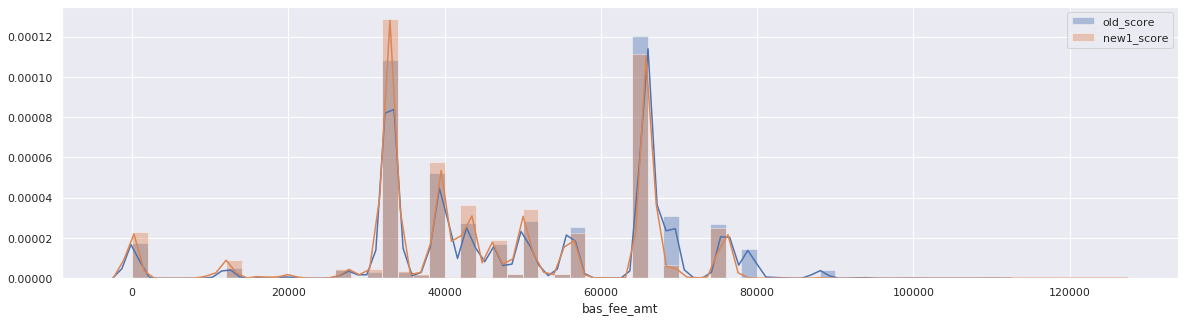

In [50]:
c1 = 'old_score'
c2 = 'new1_score'

sns.set(rc={'figure.figsize': (20,5)})

df_old = df_tst.sort_values(c1, ascending=False).iloc[:6000000,:]
df_new = df_tst.sort_values(c2, ascending=False).iloc[:6000000,:]

sns.distplot(df_old.bas_fee_amt, norm_hist=True, label=c1, bins=np.arange(0, 100000, 2000))
sns.distplot(df_new.bas_fee_amt, norm_hist=True, label=c2, bins=np.arange(0, 100000, 2000))

plt.legend()

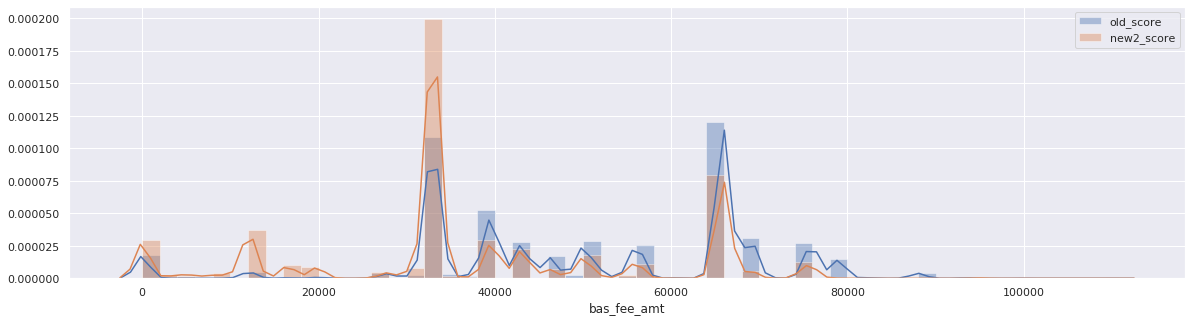

In [51]:
c1 = 'old_score'
c2 = 'new2_score'

sns.set(rc={'figure.figsize': (20,5)})

df_old = df_tst.sort_values(c1, ascending=False).iloc[:6000000,:]
df_new = df_tst.sort_values(c2, ascending=False).iloc[:6000000,:]

sns.distplot(df_old.bas_fee_amt, norm_hist=True, label=c1, bins=np.arange(0, 100000, 2000))
sns.distplot(df_new.bas_fee_amt, norm_hist=True, label=c2, bins=np.arange(0, 100000, 2000))

plt.legend()

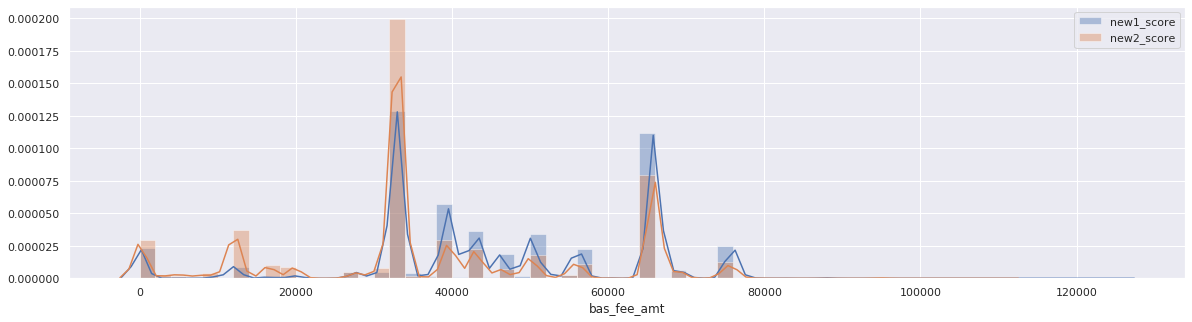

In [52]:
c1 = 'new1_score'
c2 = 'new2_score'

sns.set(rc={'figure.figsize': (20,5)})

df_old = df_tst.sort_values(c1, ascending=False).iloc[:6000000,:]
df_new = df_tst.sort_values(c2, ascending=False).iloc[:6000000,:]

sns.distplot(df_old.bas_fee_amt, norm_hist=True, label=c1, bins=np.arange(0, 100000, 2000))
sns.distplot(df_new.bas_fee_amt, norm_hist=True, label=c2, bins=np.arange(0, 100000, 2000))


plt.legend()

#### 상위 600만 impression 시 upsell 여부

In [61]:
for name in clf_dict.keys():
    print('='*50)
    print('name: ', name)
    
    score = '{}_score'.format(name)
    pred_class = '{}_pred_class'.format(name)
    
    # 상위 600만
    df_tmp = df_tst.sort_values(score, ascending=False).iloc[:6000000,:]
    df_tmp[pred_class] = 1
    
    number_of_upsell = df_tmp[(df_tmp['label_upsell_yn']==1) & (df_tmp['label_eqp_chg_yn']==0)].shape[0]
    print('upsell 회선 수: ', number_of_upsell)
    print('upsell 성공률: ', number_of_upsell/df_tmp.shape[0])

name:  old
upsell 회선 수:  143754
upsell 성공률:  0.023959
name:  new2
upsell 회선 수:  129452
upsell 성공률:  0.021575333333333332
name:  new1
upsell 회선 수:  154870
upsell 성공률:  0.025811666666666667


#### 기변 미포함 sum(diff)

In [66]:
for name in clf_dict.keys():
    print('='*50)
    print('name: ', name)
    
    score = '{}_score'.format(name)
    pred_class = '{}_pred_class'.format(name)
    
    # 상위 600만
    df_tmp = df_tst.sort_values(score, ascending=False).iloc[:6000000,:]
    df_tmp[pred_class] = 1
    
#     evaluate(df_tmp['label_upsell_yn'], df_tmp[score], df_tmp[pred_class])
    
    print('diff: ', calculate_diff(df_tmp, pred_class))

name:  old
diff:  973156560
name:  new2
diff:  1493126505
name:  new1
diff:  1243101320


#### 기변 포함

In [64]:
for name in clf_dict.keys():
    print('='*50)
    print('name: ', name)
    
    score = '{}_score'.format(name)
    pred_class = '{}_pred_class'.format(name)
    
    # 상위 600만
    df_tmp = df_tst.sort_values(score, ascending=False).iloc[:6000000,:]
    df_tmp[pred_class] = 1
    
#     evaluate(df_tmp['label_upsell_yn'], df_tmp[score], df_tmp[pred_class])
    
    print('diff: ', calculate_diff(df_tmp, pred_class))

name:  old
diff:  4382469850
name:  new2
diff:  3841805850
name:  new1
diff:  4026380000


In [73]:
df_tmp = df_tst.sort_values('old_score', ascending=False).iloc[:6000000,:]

In [74]:
df_tmp.bas_fee_amt.mean()

49999.3115825

In [72]:
df_tmp.bas_fee_amt.mean()

37442.90103916667